In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.13.0
Keras version: 2.13.1


In [2]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras import metrics

# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import (mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, confusion_matrix, precision_recall_curve)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline



## Carga y Exploración de los Datos


In [3]:
X_train = pd.read_csv(r"../Datos/MultiTrainBalanced.csv")
X_test  = pd.read_csv(r"../Datos/MultiTest1Balanced.csv")

In [4]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train.shape[0])
Y_train = X_train['CLASS_LABEL']
X_train = X_train.drop(['CLASS_LABEL'], axis=1)
print(X_train.shape, Y_train.shape)

print("\n\t\tDatos de prueba")
nr_clases = X_test['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test.shape[0])
Y_test = X_test['CLASS_LABEL']
X_test = X_test.drop(['CLASS_LABEL'], axis=1)
print(X_test.shape, Y_test.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
2    5492
1    5442
4    5434
0    5392
3    5382
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
2    20.234323
1    20.050107
4    20.020632
0    19.865891
3    19.829047
Name: count, dtype: float64
(27142, 606) (27142,)

		Datos de prueba

Cantidad  CLASS_LABEL
3    1189
0    1182
4    1167
2    1153
1    1125
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
3    20.443604
0    20.323246
4    20.065337
2    19.824622
1    19.343191
Name: count, dtype: float64
(5816, 606) (5816,)


In [5]:
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas de entrenamiento y prueba
Y_train_cod = to_categorical(Y_train)
Y_test_cod = to_categorical(Y_test)

# Mostrar las dimensiones resultantes
print("Dimensiones de Y_train_one_hot:", Y_train_cod.shape)
print("Dimensiones de Y_test_one_hot:", Y_test_cod.shape)


Dimensiones de Y_train_one_hot: (27142, 5)
Dimensiones de Y_test_one_hot: (5816, 5)


  ## Crear MPL y Búsqueda de Hiperparámetros con Keras Tuner

In [6]:
import kerastuner as kt
def build_model(hp):
  model = Sequential()
  model.add(Flatten(input_shape=(606,)))
    
  hp_units1 = hp.Int('units1', min_value=300, max_value=400, step=5)
  hp_units2 = hp.Int('units2', min_value=200, max_value=300, step=5)
  hp_units3 = hp.Int('units3', min_value=50, max_value=200, step=5)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dense(units=hp_units2, activation='relu'))
  model.add(Dense(units=hp_units3, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

  model.compile(
      optimizer=Adam(learning_rate=hp_learning_rate),
      loss='categorical_crossentropy',
      metrics=[
          metrics.CategoricalAccuracy(name="accuracy"),  # Precisión multiclase
          metrics.Recall(name="recall"),  # Recall promedio
          metrics.Precision(name="precision"),  # Precisión promedio
          metrics.AUC(name="auc", multi_label=True)  # AUC para múltiples clases
      ]
  )

  return model

In [7]:
import os

# Crear la estructura de carpetas si no existe
base_dir = "../Modelos/Tuner"

# Configurar el tuner con la carpeta deseada
tuner = kt.Hyperband(
    build_model,  # Función de construcción del modelo
    objective=kt.Objective("val_accuracy", direction="max"),  # Optimizar la precisión del conjunto de validación
    max_epochs=100,
    directory=base_dir,  # Guardar resultados en "Modelos/tuner"
    project_name='keras_tuner_mlp_multi'  # Subcarpeta para el proyecto específico
)

Reloading Tuner from ../Modelos/Tuner/keras_tuner_mlp_multi/tuner0.json


In [8]:
tuner.search(X_train, Y_train_cod, epochs=100, batch_size=128, validation_split=0.3)

### Resultados de la Búsqueda de Hiperparámetros y Modelo Óptimo

In [9]:
tuner.results_summary()

Results summary
Results in ../Modelos/Tuner/keras_tuner_mlp_multi
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0237 summary
Hyperparameters:
units1: 305
units2: 295
units3: 195
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0234
Score: 0.806705117225647

Trial 0245 summary
Hyperparameters:
units1: 345
units2: 205
units3: 200
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8028981685638428

Trial 0242 summary
Hyperparameters:
units1: 355
units2: 300
units3: 170
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7997052669525146

Trial 0201 summary
Hyperparameters:
units1: 395
units2: 280
units3: 85
learning_rate: 0.001
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0195
Score: 0.7984772324562073

Trial 0244 summary
Hyperparameters:
units1: 345


In [10]:
best_models = tuner.get_best_models(num_models=10)

In [11]:
best_models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 606)               0         
                                                                 
 dense (Dense)               (None, 305)               185135    
                                                                 
 dense_1 (Dense)             (None, 295)               90270     
                                                                 
 dense_2 (Dense)             (None, 195)               57720     
                                                                 
 dense_3 (Dense)             (None, 5)                 980       
                                                                 
Total params: 334105 (1.27 MB)
Trainable params: 334105 (1.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluación del Modelo Óptimo

In [15]:
# Evaluar el modelo en el conjunto de entrenamiento
train = best_models[0].evaluate(X_train, Y_train_cod, verbose=0)  # verbose=0 para ocultar la barra de progreso

print(train)

# Formatear la salida para mejor legibilidad
metricas = ['Loss', 'Accuracy', 'Recall', 'Precision', 'AUC']
print("\nMétricas del Modelo en el Conjunto de Entrenamiento:")
print("-" * 50)

for nombre, valor in zip(metricas, train):
    print(f"{nombre}: {valor:.4f}")

[0.3253867030143738, 0.888180673122406, 0.8724486231803894, 0.903989315032959, 0.9834929704666138]

Métricas del Modelo en el Conjunto de Entrenamiento:
--------------------------------------------------
Loss: 0.3254
Accuracy: 0.8882
Recall: 0.8724
Precision: 0.9040
AUC: 0.9835


In [16]:
# Obtener los datos del mejor ensayo desde el historial
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]  # Mejor ensayo

# Imprimir solo las métricas de validación
print("Métricas del mejor modelo en validación durante la búsqueda:")
print("-" * 50)

for metric_name in best_trial.metrics.metrics.keys():
    if "val_" in metric_name:  # Filtrar solo métricas de validación
        val_metric = best_trial.metrics.get_last_value(metric_name)
        print(f"{metric_name}: {val_metric}")


Métricas del mejor modelo en validación durante la búsqueda:
--------------------------------------------------
val_loss: 0.5838447213172913
val_accuracy: 0.806705117225647
val_recall: 0.787670373916626
val_precision: 0.8233633041381836
val_auc: 0.956769585609436


In [19]:
# Evaluar el modelo en el conjunto de prueba
test = best_models[0].evaluate(X_test, Y_test_cod, verbose=0)  # verbose=0 para ocultar la barra de progreso

# Formatear la salida para mejor legibilidad
metricas = ['Loss', 'Accuracy', 'Recall', 'Precision', 'AUC']
print("\nMétricas del Modelo en el Conjunto de Prueba:")
print("-" * 50)

for nombre, valor in zip(metricas, test):
    print(f"{nombre}: {valor:.4f}")



Métricas del Modelo en el Conjunto de Prueba:
--------------------------------------------------
Loss: 0.5866
Accuracy: 0.7956
Recall: 0.7761
Precision: 0.8166
AUC: 0.9576


## Reentrenamos el modelo

In [20]:
# Obtener los hiperparámetros del mejor modelo
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extraer los valores específicos de los hiperparámetros
optimal_hyperparameters = {
    'units1': best_hyperparameters.get('units1'),
    'units2': best_hyperparameters.get('units2'),
    'units3': best_hyperparameters.get('units3'),
    'learning_rate': best_hyperparameters.get('learning_rate')
}

# Imprimir los hiperparámetros óptimos
print("Hiperparámetros óptimos:", optimal_hyperparameters)



Hiperparámetros óptimos: {'units1': 305, 'units2': 295, 'units3': 195, 'learning_rate': 0.001}


In [41]:

# Definir la entrada explícita del modelo
input_shape = (606,)  # Ajustar según el número de características
entrada = Input(shape=input_shape)

# Construir el modelo utilizando los hiperparámetros óptimos
x = Flatten()(entrada)
x = Dense(units=optimal_hyperparameters['units1'], activation='relu')(x)
x = Dense(units=optimal_hyperparameters['units2'], activation='relu')(x)
x = Dense(units=optimal_hyperparameters['units3'], activation='relu')(x)
x = Dense(units=100, activation='relu')(x)
x = Dense(units=20, activation='relu')(x)
salida = Dense(units=5, activation='softmax')(x)

# Crear el modelo completo
modelo_completo = Model(inputs=entrada, outputs=salida)

# Compilar el modelo
modelo_completo.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss="categorical_crossentropy",
    metrics=[
          metrics.CategoricalAccuracy(name="accuracy"),  # Precisión multiclase
          metrics.Recall(name="recall"),  # Recall promedio
          metrics.Precision(name="precision"),  # Precisión promedio
          metrics.AUC(name="auc", multi_label=True)  # AUC para múltiples clases
      ]
)

# Resumen del modelo
modelo_completo.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 606)]             0         
                                                                 
 flatten_4 (Flatten)         (None, 606)               0         
                                                                 
 dense_16 (Dense)            (None, 305)               185135    
                                                                 
 dense_17 (Dense)            (None, 295)               90270     
                                                                 
 dense_18 (Dense)            (None, 195)               57720     
                                                                 
 dense_19 (Dense)            (None, 100)               19600     
                                                                 
 dense_20 (Dense)            (None, 20)                2020

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',  # Monitorea la pérdida en los datos de entrenamiento
    patience=10,     # Detiene el entrenamiento si no hay mejora en 10 épocas
    restore_best_weights=True  # Restaura los pesos del mejor modelo
)

# Entrenar el modelo sin validación y con EarlyStopping
history = modelo_completo.fit(
    X_train, Y_train_cod,
    epochs=100,  # Número máximo de épocas
    batch_size=128,
    verbose=1,  # Muestra información del progreso
    callbacks=[early_stopping]  # Agrega EarlyStopping
)


Epoch 1/100
213/213 [==============================] - 1s 3ms/step - loss: 1.2761 - accuracy: 0.4295 - recall: 0.1772 - precision: 0.7061 - auc: 0.7646
Epoch 2/100
213/213 [==============================] - 1s 3ms/step - loss: 1.1106 - accuracy: 0.5035 - recall: 0.2658 - precision: 0.6913 - auc: 0.8248
Epoch 3/100
213/213 [==============================] - 1s 3ms/step - loss: 1.0813 - accuracy: 0.5230 - recall: 0.3072 - precision: 0.6831 - auc: 0.8325
Epoch 4/100
213/213 [==============================] - 1s 3ms/step - loss: 1.0435 - accuracy: 0.5428 - recall: 0.3517 - precision: 0.6861 - auc: 0.8440
Epoch 5/100
213/213 [==============================] - 1s 3ms/step - loss: 1.0237 - accuracy: 0.5586 - recall: 0.3849 - precision: 0.6871 - auc: 0.8511
Epoch 6/100
213/213 [==============================] - 1s 3ms/step - loss: 0.9865 - accuracy: 0.5829 - recall: 0.4310 - precision: 0.7048 - auc: 0.8624
Epoch 7/100
213/213 [==============================] - 1s 3ms/step - loss: 0.9795 - accu

#### Resumen de Desempeño

In [43]:

# Guardar el modelo reentrenado
modelo_completo.save("../Modelos/Multi_MPL_best.keras")
print("Modelo reentrenado guardado exitosamente.")

Modelo reentrenado guardado exitosamente.


## Visualizacion de espacios

### Espacio original 

In [28]:
# Aplicar t-SNE directamente al conjunto original X_train
tsne_original = TSNE(n_components=2, random_state=42)
X_train_2D = tsne_original.fit_transform(X_train)

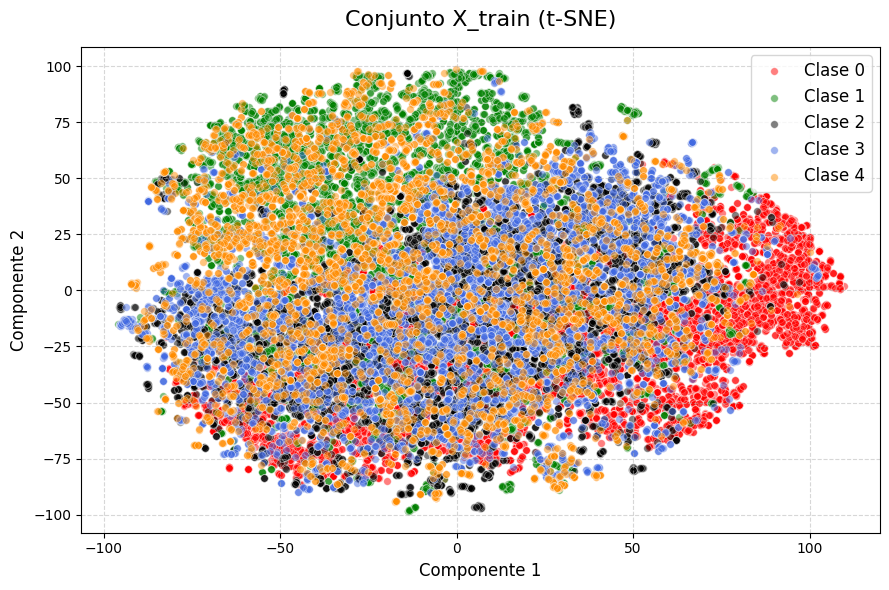

In [35]:
# Visualizar el conjunto original utilizando un scatter plot
plt.figure(figsize=(9, 6))
colores = ['red','green','black','royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0,1,2,3,4]):
    indices = Y_train == clase
    plt.scatter(
        X_train_2D[indices, 0], 
        X_train_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.5,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Conjunto X_train (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()


### Espacio latente

In [44]:
# Crear un modelo intermedio que llegue hasta la tercera capa oculta
modelo_intermedio = Model(
    inputs=modelo_completo.input,
    outputs=modelo_completo.layers[-2].output  # Salida de la capa oculta 
)

# Generar las predicciones del espacio latente para el conjunto de datos (ejemplo: X_test)
espacio_latente = modelo_intermedio.predict(X_train)

# Imprimir el número de observaciones y características
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones del espacio latente X_train: {espacio_latente.shape}")


849/849 [==============================] - 1s 644us/step
Dimensiones de X_train: (27142, 606)
Dimensiones del espacio latente X_train: (27142, 20)


In [45]:
# Aplicar t-SNE para reducir las dimensiones del espacio latente a 2D
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)

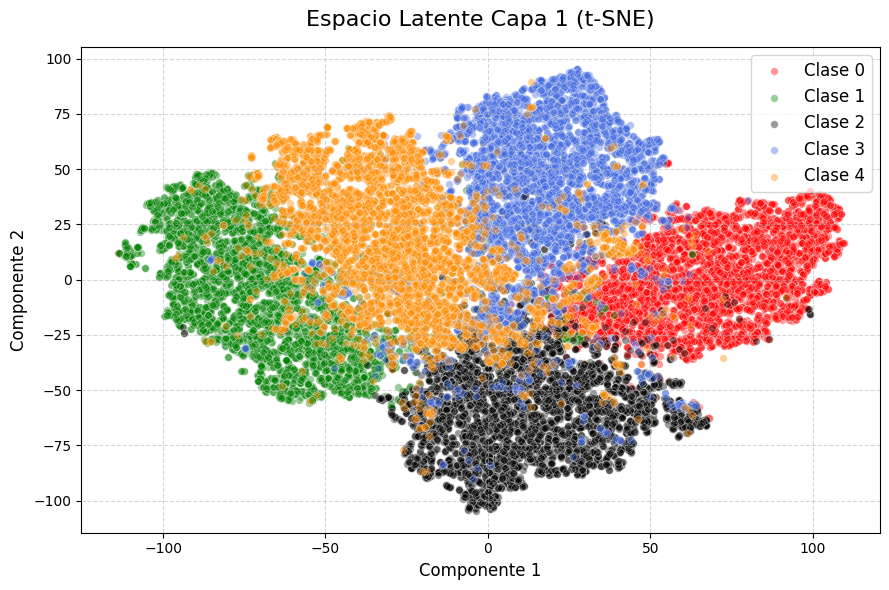

In [46]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['red','green','black','royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0,1,2,3,4]):
    indices = Y_train == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente Capa 1 (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()